In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

In [3]:
acc_dtypes = {
    "place":"category",
    "catu":"category",
    "grav":"category",
    "sexe":"category",
    "trajet":"category",
    "locp":"category",
    "actp":"category",
    "etatp":"category",
    "secuUn":"category",
    "secuDeux":"category",
    "tranches_ages":"category",
    "catr":"category",
    "circ":"category",
    "vosp":"category",
    "prof":"category",
    "plan":"category",
    "surf":"category",
    "infra":"category",
    "situ":"category",
    "senc":"category",
    "obs":"category",
    "obsm":"category",
    "choc":"category",
    "manv":"category",
    "catv_Label":"category",
    "lum":"category",
    "agg":"category",
    "int":"category",
    "atm":"category",
    "col":"category",
    "jour_de_la_semaine":"category",
    "heure":"category",
    "dep": "category"
    }
df = pd.read_csv(r"C:\Users\maill\Documents\GitHub\SARA\data\fusion3.csv", low_memory=False)
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['Unnamed: 0','num_acc','an_nais','an_naiss','age_acc_an','num_veh','senc','occutc','permis','secuDeux','date','com'], axis=1)
df['place'] = df['place'].astype('object')
df['dep'] = df['dep'].replace({'2A':201,'2B':202})
df['dep'] = df['dep'].astype('int64')

df = df.dropna()

In [37]:
X = df.drop('grav',axis=1)
y = df['grav']

ohe = OneHotEncoder()
categorical_variable = make_column_selector(dtype_exclude=np.number)

X = ohe.fit_transform(X)


#X, _, y, _ = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(X_train.shape)

(2291745, 481)
(3000772, 481)


In [ ]:
# categorical_variable = make_column_selector(dtype_exclude=np.number)
# encoder = make_column_transformer((OneHotEncoder(), categorical_variable))

# model = ImbPipeline(steps=[('transformer', encoder),('undersampling', RandomUnderSampler(random_state=42)),('classifier', RandomForestClassifier(random_state=42))], verbose=True)




# Recherche des meilleurs paramètres
objectifs : reduire l'overfitting et optimiser la performance du modèle grâce au f1_score

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 20)], # Nombre d'arbres
    'max_depth': [int(x) for x in np.linspace(10, 50, num = 11)], # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [2, 4, 6], # Nombre minimum d'échantillons requis à chaque nœud feuille
    'min_impurity_decrease': [0.0, 0.01, 0.1], # Seuil pour une réduction minimale de l'impureté
    'ccp_alpha': [0.0, 0.01, 0.1] # Paramètre de complexité utilisé pour l'élagage minimal des coûts-complexité
}

# Créer le modèle de base à tuner
rf = RandomForestClassifier()

n_folds = StratifiedKFold(n_splits=3)

f1_scorer = make_scorer(f1_score, average='macro')

# rechercher dans 100 différentes combinaisons
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid,
                               n_iter = 10, cv = n_folds, scoring=f1_scorer, verbose=1, random_state=42, n_jobs = -1)

# Ajuster le modèle RandomizedSearchCV
rf_random.fit(X_train, y_train)

best_params = rf_random.best_params_

    # Afficher les meilleurs paramètres actuels
print(f"meilleurs paramètres: {best_params}")
print(f"meilleur score : {rf_random.best_score_})

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 38, 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_depth': 42, 'ccp_alpha': 0.0}


0.7567262831900902

# Courbe d'apprentissage

In [29]:
np.logspace(np.log10(0.01), np.log10(1.0), 10)

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

In [32]:
np.linspace(0.0001, 1.0, 10)

array([1.000e-04, 1.112e-01, 2.223e-01, 3.334e-01, 4.445e-01, 5.556e-01,
       6.667e-01, 7.778e-01, 8.889e-01, 1.000e+00])

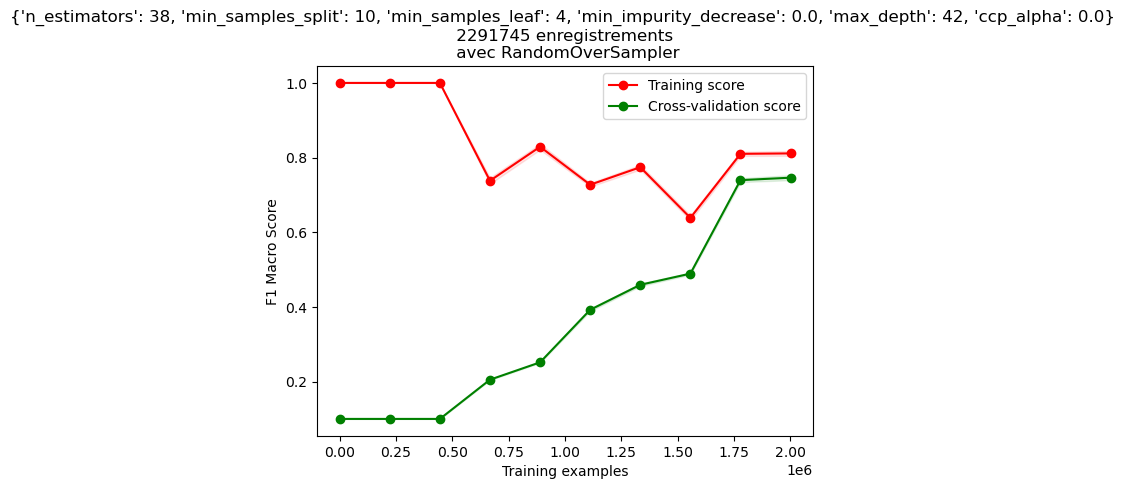

In [38]:
estimator = rf_random.best_estimator_
train_scores = []
test_scores = []
n_folds = StratifiedKFold(n_splits=3)
# fonction learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=n_folds, scoring='f1_macro',
                                                        train_sizes=np.linspace(0.0001, 1.0, 10))

# Calculer la moyenne et l'écart type pour les scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title(f'{rf_random.best_params_} \n {X.shape[0]} enregistrements \n avec RandomOverSampler')
plt.xlabel("Training examples")
plt.ylabel("F1 Macro Score")
plt.legend(loc="best")
plt.show()


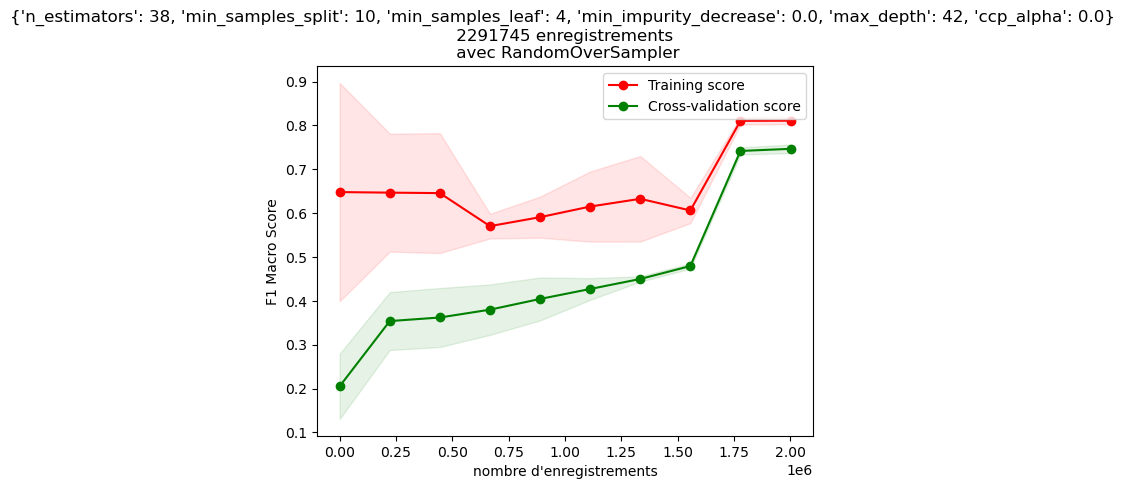

In [35]:
# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title(f'{rf_random.best_params_} \n {X.shape[0]} enregistrements \n avec RandomOverSampler')
plt.xlabel("nombre d'enregistrements")
plt.ylabel("F1 Macro Score")
plt.legend(loc="best")
plt.show()

In [19]:
y_pred = rf_random.best_estimator_.predict(X_test)
print(f"{rf_random.best_params_} \n {X.shape[0]} enregistrements \n avec RandomOverSampler")
print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print(classification_report(y_test, y_pred))

{'n_estimators': 38, 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_depth': 42, 'ccp_alpha': 0.0} 
 2291745 enregistrements 
 avec RandomOverSampler
Classe prédite      Blessé hospitalisé  Blessé léger  Indemne   Tué
Classe réelle                                                      
Blessé hospitalisé               50887         25325    13122  4609
Blessé léger                     34706         87683    40632  1670
Indemne                          13821         19805   152585  1342
Tué                               7047          1301     1292  2522
                    precision    recall  f1-score   support

Blessé hospitalisé       0.48      0.54      0.51     93943
      Blessé léger       0.65      0.53      0.59    164691
           Indemne       0.73      0.81      0.77    187553
               Tué       0.25      0.21      0.23     12162

          accuracy                           0.64    458349
         macro avg       0.53      0.52      

# Precision Recall Curve

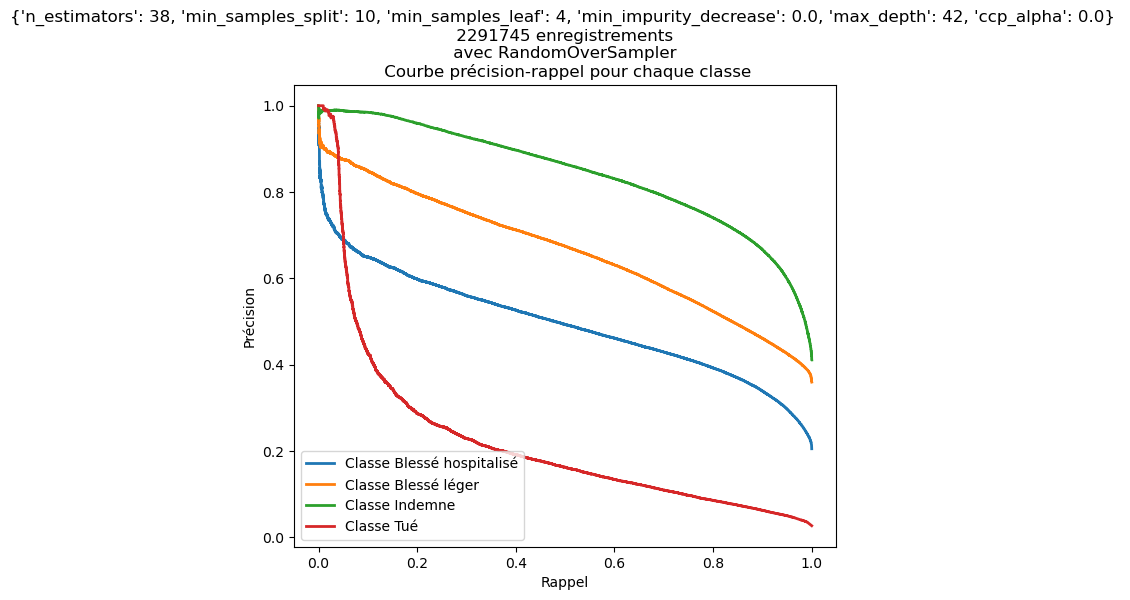

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Initialiser le LabelEncoder
le = LabelEncoder()

# Ajuster le label encoder et transformer les étiquettes de classe en entiers
y_test_encoded = le.fit_transform(y_test)

# Ajuster le modèle et obtenir les probabilités prédites pour l'ensemble de test
y_proba = rf_random.predict_proba(X_test)

# Nombre de classes
n_classes = y_proba.shape[1]

# Binariser les étiquettes de classe pour correspondre à `y_proba`
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test_encoded, classes=range(n_classes))

# Calcul de la précision et du rappel pour chaque classe
precision = dict()
recall = dict()
thresholds = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], y_proba[:, i])

# Tracer les courbes de précision-rappel pour chaque classe
plt.figure(figsize=(7, 6))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Classe {le.classes_[i]}')

plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title(f"{rf_random.best_params_} \n {X.shape[0]} enregistrements \n avec RandomOverSampler \n Courbe précision-rappel pour chaque classe")
plt.legend(loc="best")
plt.show()
